In [12]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import pandas as pd

file_path = "/content/drive/MyDrive/prepared_crunchbase_for_regression.csv"  # ← update this
df = pd.read_csv(file_path)

print("✅ Loaded dataset. Shape:", df.shape)


✅ Loaded dataset. Shape: (40907, 876)


In [ ]:
!pip install imbalanced-learn


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.inspection import permutation_importance
import joblib


# Drop any rows with missing target
df = df.dropna(subset=["success_score"])

# Automatically one-hot encode any object-type (non-numeric) columns
categorical_cols = df.select_dtypes(include="object").columns.tolist()
print(f"🧼 One-hot encoding categorical columns: {categorical_cols}")
df = pd.get_dummies(df, columns=categorical_cols)

# Separate features and target
print("📊 Splitting features and target...")
X = df.drop(columns=["success_score"])
y = df["success_score"]
# Train-test split
print("🔀 Splitting into 80/20 train-test...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
print("🚜 Training Random Forest Regressor...")
model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# Save model
joblib.dump(model, "random_forest_model.pkl")
print("💾 Model saved to random_forest_model.pkl")

# Predict
print("📈 Making predictions...")
y_pred = model.predict(X_test)

# Evaluate
print("📏 Evaluating model...")
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

mae = mean_absolute_error(y_test, y_pred)

print(f"\n=== 📊 Evaluation Metrics ===")
print(f"R² Score:  {r2:.4f}")
print(f"RMSE:      {rmse:.4f}")
print(f"MAE:       {mae:.4f}")

# Plot predictions
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.xlabel("Actual Success Score")
plt.ylabel("Predicted Success Score")
plt.title("Actual vs Predicted Success Score")
plt.grid(True)
plt.show()

# Permutation Feature Importance
print("🔍 Calculating Permutation Feature Importance (fast mode)...")
perm = permutation_importance(model, X_test, y_test, n_repeats=3, random_state=42, n_jobs=-1)

sorted_idx = perm.importances_mean.argsort()[::-1][:20]
top_features = X.columns[sorted_idx]
importances = perm.importances_mean[sorted_idx]

# Plot top 20 important features
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=top_features)
plt.title("Top 20 Permutation Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


🧼 One-hot encoding categorical columns: ['state_code']
📊 Splitting features and target...
🔀 Splitting into 80/20 train-test...
🚜 Training Random Forest Regressor...
💾 Model saved to random_forest_model.pkl
📈 Making predictions...
📏 Evaluating model...


TypeError: got an unexpected keyword argument 'squared'

📦 Loading model from file...
📈 Making predictions...
📏 Evaluating model...

=== Evaluation ===
R² Score: 0.6826
RMSE:     0.0565
MAE:      0.0380


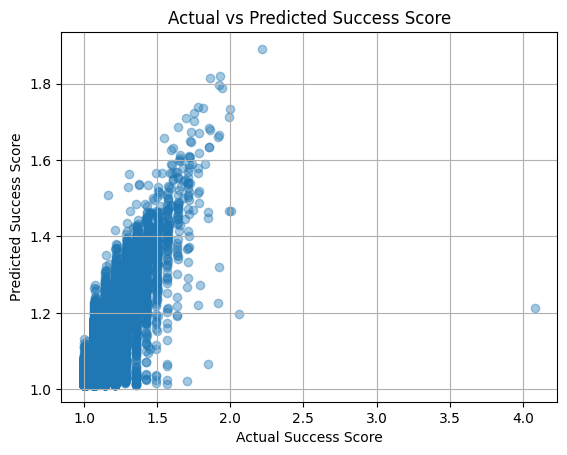

In [20]:
import pandas as pd
import joblib
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# === Load preprocessed dataset ===


# === Prepare features and target ===
X = df.drop("success_score", axis=1)
y = df["success_score"]

# === Load model ===
print("📦 Loading model from file...")
model = joblib.load("random_forest_model.pkl")

# === Predict ===
print("📈 Making predictions...")
y_pred = model.predict(X)

# === Evaluate ===
print("📏 Evaluating model...")
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
mae = mean_absolute_error(y, y_pred)

print("\n=== Evaluation ===")
print(f"R² Score: {r2:.4f}")
print(f"RMSE:     {rmse:.4f}")
print(f"MAE:      {mae:.4f}")

# === Plot Actual vs Predicted ===
plt.scatter(y, y_pred, alpha=0.4)
plt.xlabel("Actual Success Score")
plt.ylabel("Predicted Success Score")
plt.title("Actual vs Predicted Success Score")
plt.grid(True)
plt.show()


📦 Loading model...
📄 Loading feature data...
✅ Feature data shape: (40907, 876)
📊 Extracting feature importances...
✅ Saved top features to 'top_feature_importance.csv'


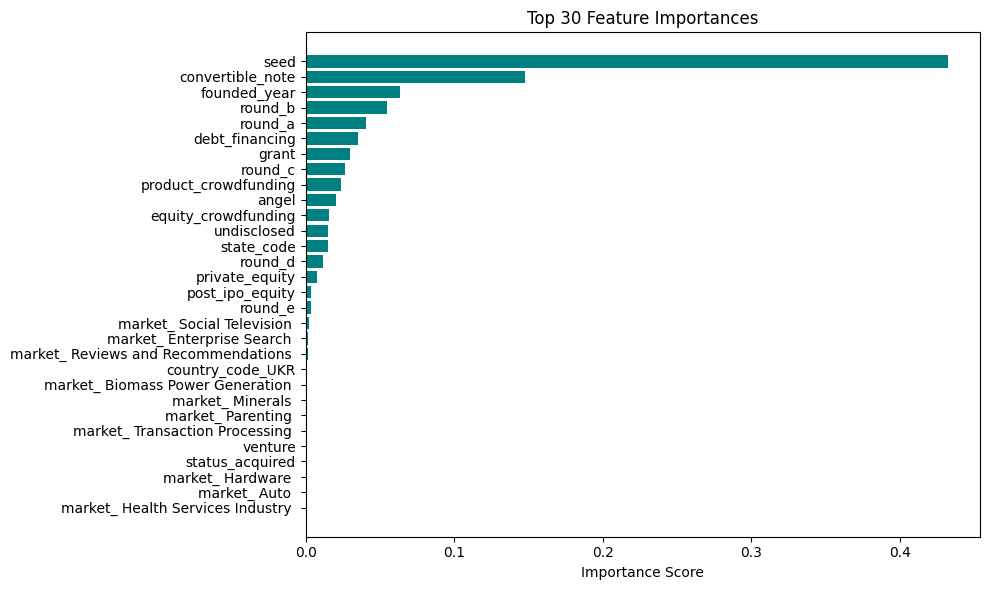

In [30]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

# === Load model and dataset ===
model_path = "/content/random_forest_model.pkl"
data_path = "/content/drive/MyDrive/prepared_crunchbase_for_regression.csv"

print("📦 Loading model...")
model = joblib.load(model_path)

print("📄 Loading feature data...")
X = pd.read_csv(data_path)
print("✅ Feature data shape:", X.shape)

# === Get model importances ===
print("📊 Extracting feature importances...")
importances = model.feature_importances_

# Clip importances if model expects more features than current data
valid_size = min(len(importances), X.shape[1])
importances = importances[:valid_size]
feature_names = X.columns[:valid_size]

# === Top N features ===
top_n = 30
top_indices = np.argsort(importances)[::-1][:top_n]

top_features = pd.DataFrame({
    "feature": feature_names[top_indices],
    "importance": importances[top_indices]
})

# === Save to CSV ===
top_features.to_csv("top_feature_importance.csv", index=False)
print("✅ Saved top features to 'top_feature_importance.csv'")

# === Plot ===
plt.figure(figsize=(10, 6))
plt.barh(top_features["feature"], top_features["importance"], color="teal")
plt.gca().invert_yaxis()
plt.title("Top 30 Feature Importances")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()
